In [121]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import jaxgp.regression as gpr
from jaxgp.kernels import RBF, Linear
import time

import testfunctions
from jaxgp.utils import Logger

### 1D

In [133]:
from jax import vmap, jit, grad

def f(x):
    return jnp.exp(-x**2) + jnp.exp(-0.5*(x-0.5)**2)

def df(x):
    return -2*x*jnp.exp(-x**2) + -(x-0.5)*jnp.exp(-0.5*(x-0.5)**2)

In [135]:
seed = 0

noise = 0.1
range = jnp.array([0.0, 1.0])
num_datapoints = 1000
X_train = jnp.linspace(*range, num_datapoints).reshape(-1,1)
y = f(X_train)
dy = df(X_train)
Y_train = jnp.hstack((y, dy))

print(X_train.shape, Y_train.shape)

(1000, 1) (1000, 2)


### 2D

In [124]:
def function(x):
    return jnp.sin(2*x[0] + x[1])

In [125]:
optimizers = ["Nelder-Mead", "L-BFGS-B", "TNC", "SLSQP", "Powell", "trust-constr"]

seed = 0
num_gridpoints = jnp.array([100,100])
num_datapoints = jnp.prod(num_gridpoints)
noise = 0.5
ranges = (jnp.array([0,2*jnp.pi]),jnp.array([0,2*jnp.pi]))
# fun = testfunctions.franke
fun = function

X_train, Y_train = testfunctions.create_training_data_2D(seed, num_gridpoints, ranges, noise, fun)
# X_train, Y_train = make_unique(X_train, Y_train)

iters_per_optimizer = 1

# function_set_sizes = [1, 5, 10, 50, 100]
function_set_sizes = [100,]
# derivative_set_sizes = [10, 50, 100, 500, 1000, 2000, 5000]
derivative_set_sizes = [100,]

kernel = RBF()
param_shape = (2,)
param_bounds = (1e-3, 10.0)

grids = jnp.linspace(0,2*jnp.pi,20)
grid = jnp.array(jnp.meshgrid(grids, grids)).reshape(2,-1).T

In [126]:
key = random.PRNGKey(int(time.time()))

means = []
stds = []

for fun_vals in function_set_sizes:
    for der_vals in derivative_set_sizes:
        # logger for each pair of function vals and derivative vals
        logger = Logger(f"f{fun_vals}d{der_vals}")

        # X = X_train.reshape(100,100,2)
        # Y = Y_train.reshape(100,100,3)

        # X_fun = X[::10,::10].reshape(100,2)
        # Y_fun = Y[::10,::10,0].reshape(-1)
        # X_d1 = X[::10,::10].reshape(100,2)
        # Y_d1 = Y[::10,::10,1].reshape(-1)
        # X_d2 = X[::10,::10].reshape(100,2)
        # Y_d2 = Y[::10,::10,2].reshape(-1)

        key, subkey = random.split(key)
        fun_perm = random.permutation(subkey, num_datapoints)[:fun_vals]
        key, subkey = random.split(key)
        d1_perm = random.permutation(subkey, num_datapoints)[:der_vals]
        key, subkey = random.split(key)
        d2_perm = random.permutation(subkey, num_datapoints)[:der_vals]

        X_fun = X_train[fun_perm]
        Y_fun = Y_train[fun_perm,0]
        X_d1 = X_train[d1_perm]
        Y_d1 = Y_train[d1_perm,1]
        X_d2 = X_train[d2_perm]
        Y_d2 = Y_train[d2_perm,2]

        X = jnp.vstack((X_fun, X_d1, X_d2))
        Y = jnp.hstack((Y_fun, Y_d1, Y_d2))
        data_split = jnp.array([function_set_sizes, derivative_set_sizes, derivative_set_sizes])
        # data_split = jnp.array([100, 100, 100])

        # print(X.shape, Y.shape, data_split)
        # print()

        for i in range(iters_per_optimizer):
            key, subkey = random.split(key)
            init_params = random.uniform(subkey, param_shape, minval=param_bounds[0], maxval=param_bounds[1])
            init_params = jnp.array([1.0, 1.0])

            model = gpr.ExactGPR(kernel, init_params, noise)
            model.train(X, Y, data_split=data_split)
            m, s = model.eval(grid)
            means.append(m)
            stds.append(s)

OptStep(params=DeviceArray([1., 1.], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(nan, dtype=float32, weak_type=True), success=False, status=2, iter_num=0))


In [127]:
print(fun_perm)
print(d1_perm)
print(d2_perm)

[7814 9159 3406 5316  133 7195 6422 5190 2167 9251 3887 4262  167 5695
 2328 8527 3387 1564  997 6007 6885 5993 1772 1477 3175 6992 1022 3897
 8570 6292 5985 2139  229 2040 8385 4426 4260 8753 2126 4333 5556 3783
  985 4275 1566 6936 8326 2909 4032 5978 2645 6722 1400 1260 3322 5918
 5891 4844 1409 2861 7419 8391 1680 9530 3125 4342 3868 9258 7211 1928
 7839 8749 9849  707 1177 3600 2353 2010 5176 8951 7032 5606 7383 7189
 1212 4801 9343  309  238 2083 2338 5875 7504 7272 6882 9513 5006 1185
  508 1366]
[ 169 6098  303 4717 1896 2982  577 9045 7722 2908 9639 5722 7310 4841
 6951 3836 4641 9386 5383 6283 2106 5768 1722  837 1397 2772 7477 2254
 9945 1603 6028 6771 4160 1625 8629 8851 2556 6842 9540 8880 8966 5491
 4582 8479 9616 1225 1029 7320 3794 5063 4556 2784 1620 4585 9827 1204
 6272 4109  629 4016 9088 4351 9322 4823  254 6233 1561 1193 8219 1876
 4157 3485 4189 2365 6785 4215   46 1012 6415 7816 1302 6086 4817   50
 2945 1276 2813 3462  736 1145 2826 5509 1240 3801 5848 6896 4541

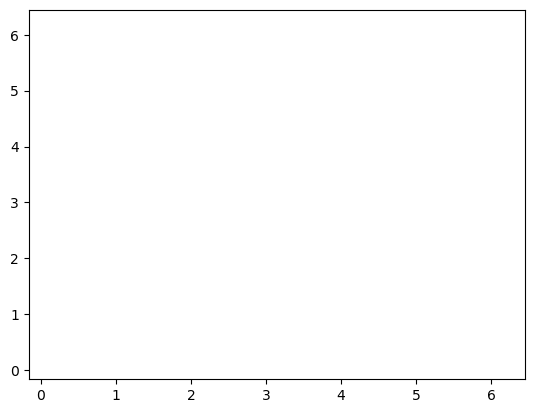

In [128]:
mean = means[0].reshape(20,20)

plt.pcolormesh(grids, grids, mean)

### tangent plotting helper

In [129]:
def plot_tangent(ax,x0, y0, dy0):
    x = jnp.linspace(x0-0.1, x0+0.1,2)
    tangent = dy0*(x - x0) + y0

    ax.plot(x, tangent,ls="--", color="red")